# Schlögl Model — Example and Usage Guide

This notebook provides a clean, publication-ready walkthrough for simulating and visualizing the **Schlögl model** (also known as the **bistable autocatalytic reaction model**).

**What you will learn**
- How to set up parameters and simulate the model (deterministic and/or stochastic, depending on code cells).
- How to visualize trajectories and interpret results.

**Dependencies**
- Python 3.9+ (recommended)
- `numpy`, `scipy`, `matplotlib`, `torch`

> Tip: create and activate a virtual environment, then follow the installation instructions in the README.


# The spatially extended Schlögl model: A Bistable Reaction-Diffusion System
This document uses the Schlögl Model as a paradigm to illustrate the application of our research work, with a specific focus on its dynamics within a spatially extended reaction-diffusion system. The Schlögl model is a canonical example of a chemical reaction system noted for its bistability within specific parameter regimes.

The classical Schlögl model involves three chemical species, where the concentrations of species $A$ and $B$ are held constant, while the copy number of species $X$ evolves stochastically through the following reversible reactions:

\begin{align*}
2X + A \xrightleftharpoons[\tilde{c}_2]{\tilde{c}_1} 3X, \quad
 B \xrightleftharpoons[\tilde{c}_4]{\tilde{c}_3} X,
\end{align*}
where $\tilde{c}_i, i=1,2,3,4 $ are the corresponding reaction rate constants. The condition that $A$ and $B$ are kept constant is crucial for maintaining the system in a non-equilibrium state, a necessary prerequisite for bistability.

Extending this model to study spatially extended reaction-diffusion systems. We consider the system on a one-dimensional lattice consisting of $L$ voxels.

Each voxel $i$ ($i = 1, \dots, L$) hosts a well-mixed copy of the Schlögl reaction network. The voxels are coupled to their nearest neighbors via the diffusion of species $X$. $X_i$ denotes the number of $X$ molecules in voxel $i$.

The inter-voxel diffusion dynamics are governed by:
$$ 
X_i \xrightleftharpoons[d]{} X_{i\pm1},
$$
where $d$ is the diffusion rate.
The dynamics of the entire system are thus governed by the combination of local chemical reactions and inter-voxel diffusion events.

<img src="Fig_Schlogl.png" width="50%">

*Fure ig1: Schematic of the reactions in the extended Schlögl model*
*

The corresponding schematic of the reactions is shown in 1ogl}.

You can modify the Schlögl model parameters in the `.\nncme\systems\schlogl.py` file.

In [ ]:
# Parameters
#!/bin/bash

#SBATCH --job-name=default_job_name
#SBATCH --ntasks=1
#SBATCH --nodes=1
#SBATCH --gres=gpu:1
#SBATCH --partition=fat3t
#SBATCH -o out/%j.out
#SBATCH -e out/%j.err
#SBATCH -t 13-2:00:00

# Define your parameters
L=2
Sites=2
Para=1
Model="Schlogl"
net="NADE"
net_width=16
method="SGD"
epoch=100
lr=0.005
batch_size=2000
ESNumber=500
Tstep=100001
dt=0.00001
sampling='alpha'
alpha=0.3
reweighted=true

# Construct the job name dynamically
JOB_NAME="${Model}-Sites${Sites}-Para${Para}-${net}-width${net_width}-${method}-batch${batch_size}-epoch${epoch}-lr${lr}-Tstep${Tstep}-sampling${sampling}${ESNumber}_alpha${alpha}_reweighted${reweighted}"
scontrol update JobId=$SLURM_JOB_ID JobName=$JOB_NAME

module purge

# Run your Python script
if [ "$reweighted" = true ]; then
    RW_FLAG="--reweighted"
else
    RW_FLAG="--noreweight"
fi

CUDA_LAUNCH_BLOCKING=1 python3 MasterEq.py \
    --L $L --Sites $Sites --L_label X1 X2 --L_plot 0 1 --M 85 --Model $Model \
    --net $net --method $method --lossType 'kl' --epoch0 50 --epoch $epoch \
    --d_model 4 --d_ff 8 --n_layers 2 --n_heads 2 \
    --lr $lr --net_depth 1 --net_width $net_width --batch_size $batch_size \
    --Tstep $Tstep --delta_t $dt --cuda 0 --dtype float64 --num_prints 100 \
    --num_plots 10 --Para $Para --sampling $sampling --ESNumber $ESNumber \
    --alpha $alpha $RW_FLAG

#exit 0


To run the code, you need to submit the `schlogl.sh` file to the SLURM scheduler using the following command:
```
sbatch schlogl.sh
```

And you can adjust the hyperparameters of running the model in the `schlogl.sh` file, shown as follows:

You can find the results in `./out/xxx` folder, and I will introduce how to use these results in the next section.

### Load Results

In [ ]:
import numpy as np

# load VAN and corresponding SSA data
pathVAN = './out/Schlogl2_random.npy'
dataVAN = np.load(pathVAN, allow_pickle=True).item()
VAN_SampleSum = dataVAN['SampleSum']  # (T,batch,L)

pathSSA = './SSA_result/Schlogl2D_1x2_times100000_T1.0_nb1.0'
dataSSA = np.load(pathSSA + '.npz')
SSA_SampleSum = dataSSA['species'] # (T,L,batch)

# For VAN results
Tstep = dataVAN['argsSave'][0] # number of time steps for all training
delta_t = dataVAN['argsSave'][1] # step by step time interval
L = dataVAN['argsSave'][2] # species number
M = dataVAN['argsSave'][3] # the upper limit of the molecule number
initD = dataVAN['argsSave'][5] # the mean of delta distribution at initial time
print_step = dataVAN['argsSave'][6] # print step for VAN for the saving data
time_points_VAN = np.arange(0, Tstep * delta_t, print_step * delta_t)  # time points for VAN data

# For SSA results
traj_num = dataSSA['times']  # number of SSA trajectories
time_points_SSA = dataSSA['time_points']  # time points for SSA data


You can check the results in your output directory. The data will be saved in the file "data.npy", while the net parameter at each print time step will be saved in the file "nets_dict.pt". You can load the trained-net using `nncme.networks.load_nets.py`.

In [ ]:
# print shapes and keys
print("VAN_SampleSum.shape: ", VAN_SampleSum.shape)
print("SSA_SampleSum.shape: ", SSA_SampleSum.shape)

print("dataVAN.keys(): ", dataVAN.keys())
print("dataSSA.keys(): ", dataSSA.files)


VAN_SampleSum.shape:  (101, 100000, 2)
SSA_SampleSum.shape:  (100, 2, 100000)
dataVAN.keys():  dict_keys(['argsSave', 'Lossmean', 'Lossstd', 'SampleSum', 'delta_TSum'])
dataSSA.keys():  ['times', 'comput_time', 'Schlogl_args', 'time_points', 'species']


### Plotting the results compared with SSA

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import math

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
jet = plt.get_cmap('jet')
Number=15
jet_12_colors = jet(np.linspace(0, 1, Number))
color1=jet_12_colors[0,:]
color2=jet_12_colors[4,:]
color3=jet_12_colors[12,:]
color4=jet_12_colors[8,:]
color=[color1,color2,color3,color4]
jet= jet(np.linspace(0, 1, 16))

Sites = L
X1,X2,X3=0,1,2
color=['C0','C1','C2','C3','C4','C5','C6','C7','C8']
colors = [f'C{i}' for i in range(Sites)]  # Adjusting colors dynamically
plotlist = np.unique(np.floor(np.linspace(1, Sites, 4) - 1)).astype(int)
legend = [f'X{i+1}' for i in plotlist]

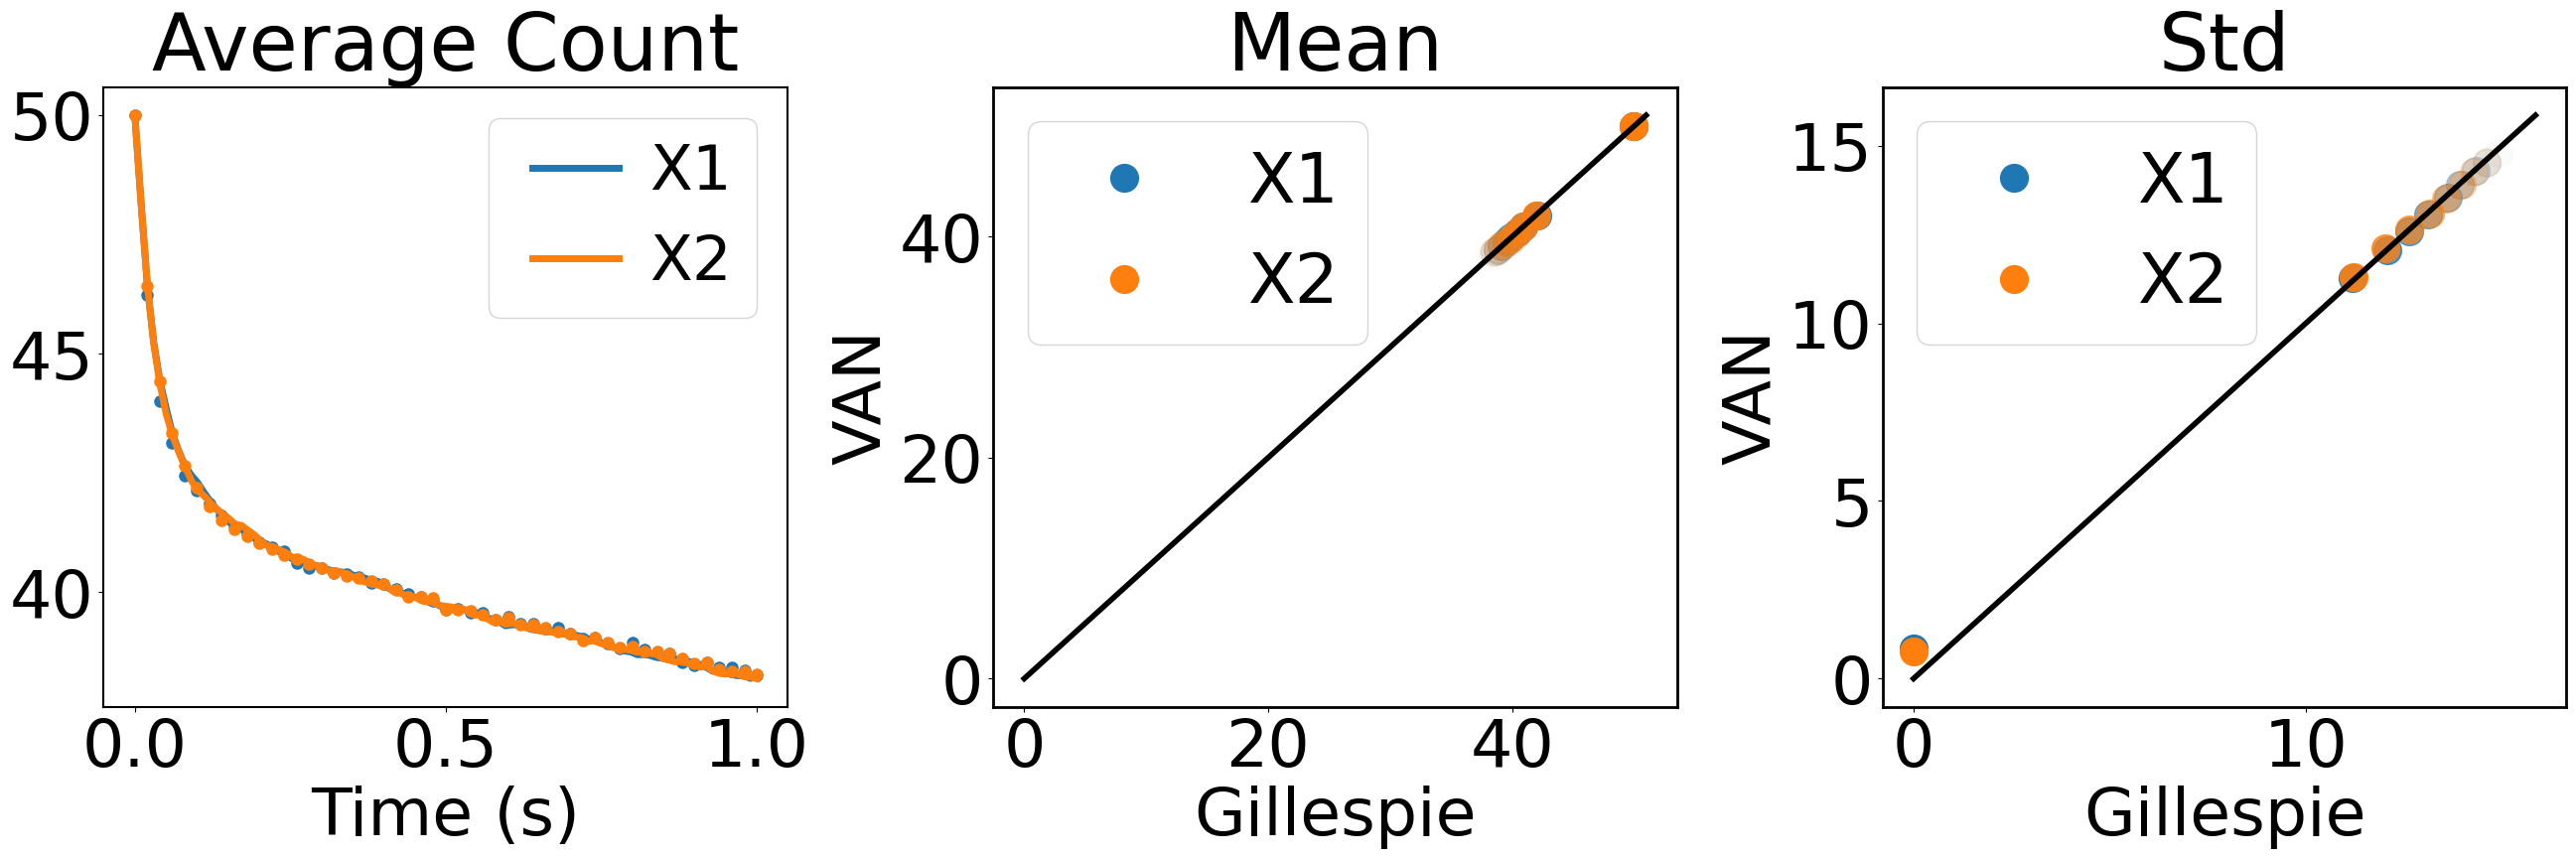

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(32, 8),dpi=100)
for ax in axes.flatten():
    ax.tick_params(axis='x', labelsize=48)  
    ax.tick_params(axis='y', labelsize=48) 
    ax.set_xlabel('',fontsize=48)  
    ax.set_ylabel('',fontsize=48) 

###curve------------------------
plt.rc('font', size=48)
markersize0=8
step=2
ax=axes[0]
i=0
for Species in plotlist:
    ax.plot(time_points_SSA,np.mean(SSA_SampleSum[:,Species,:],1),linewidth=5,color=color[i],label=legend[i])
    ax.plot(time_points_VAN[::step],np.mean(VAN_SampleSum[:,:,Species][::step],axis=1),
              marker='o',linestyle = 'None',markersize=markersize0,color=color[i])
    i=i+1

ax.set_xlabel("Time (s)")
ax.legend(numpoints=2,handletextpad=0.2,fontsize=45,loc='upper right')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.set_title('Average Count')


#####mean-----------------------------------
legendsize=50
T=min(max(time_points_VAN),max(time_points_SSA))
NumPoints=10
markersize0=20
transparency=1-np.linspace(0, 0.99,NumPoints)
a=max(np.mean(VAN_SampleSum[:,:,X1],axis=1))+1
Range=[0,a]

ax=axes[1]
i=0
for Species in plotlist:#[1,2,5]:
    k=0
    for tt in np.linspace(0,T,NumPoints):
        indexa=np.argmin(np.abs(time_points_SSA - tt))
        indexb=np.argmin(np.abs(time_points_VAN - tt))
        if tt==0:
            ax.plot(np.mean(SSA_SampleSum[indexa,Species,:]),np.mean(VAN_SampleSum[:,:,Species],axis=1)[indexb],
                      alpha=transparency[k], marker='o',linestyle = 'None',color=color[i],markersize=markersize0,label=legend[i])
        else:
            ax.plot(np.mean(SSA_SampleSum[indexa,Species,:]),np.mean(VAN_SampleSum[:,:,Species],axis=1)[indexb],
                      alpha=transparency[k], marker='o',linestyle = 'None',color=color[i],markersize=markersize0)
        k=k+1
    i=i+1    
ax.plot(Range,Range,linewidth=4,color='black')

ax.set_xlabel('Gillespie')
ax.set_ylabel('VAN')
ax.set_title('Mean')
ax.legend(fontsize=legendsize,loc='best')
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
#####std-----------------------------------
legendsize=50
T=min(max(time_points_VAN),max(time_points_SSA))
NumTimePoints=10
markersize0=20
transparency=1-np.linspace(0, 0.99, NumPoints)
a=max(np.std(VAN_SampleSum[:,:,X1],axis=1))+1
Range=[0,a]

ax=axes[2]
i=0
for Species in plotlist:#[1,2,5]:
    k=0
    for tt in np.linspace(0,T,NumPoints):
        indexa=np.argmin(np.abs(time_points_SSA - tt))#int(tt/Gstep)
        indexb=np.argmin(np.abs(time_points_VAN - tt))#[int(tt/np.max(TimePoins)*TimePoins.shape[0])]
        if tt==0:
            ax.plot(np.std(SSA_SampleSum[indexa,Species,:]),np.std(VAN_SampleSum[:,:,Species],axis=1)[indexb],
                      alpha=transparency[k], marker='o',linestyle = 'None',color=color[i],markersize=markersize0,label=legend[i])
        else:
            ax.plot(np.std(SSA_SampleSum[indexa,Species,:]),np.std(VAN_SampleSum[:,:,Species],axis=1)[indexb],
                      alpha=transparency[k], marker='o',linestyle = 'None',color=color[i],markersize=markersize0)
        k=k+1
    i=i+1    
ax.plot(Range,Range,linewidth=4,color='black')

ax.set_xlabel('Gillespie')
ax.set_ylabel('VAN')
ax.set_title('Std')
ax.legend(fontsize=legendsize,loc='best')
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.subplots_adjust(hspace=0.4,wspace=0.3,bottom=0.1)
plt.show()


0.10101010101010102 0.1
Hellinger Distance: 0.011277113534630817
Hellinger Distance: 0.011200083149825698
0.494949494949495 0.5
Hellinger Distance: 0.012586922793616671
Hellinger Distance: 0.012866035313456512
1.0 1.0
Hellinger Distance: 0.013048323387262637
Hellinger Distance: 0.01109594819365022


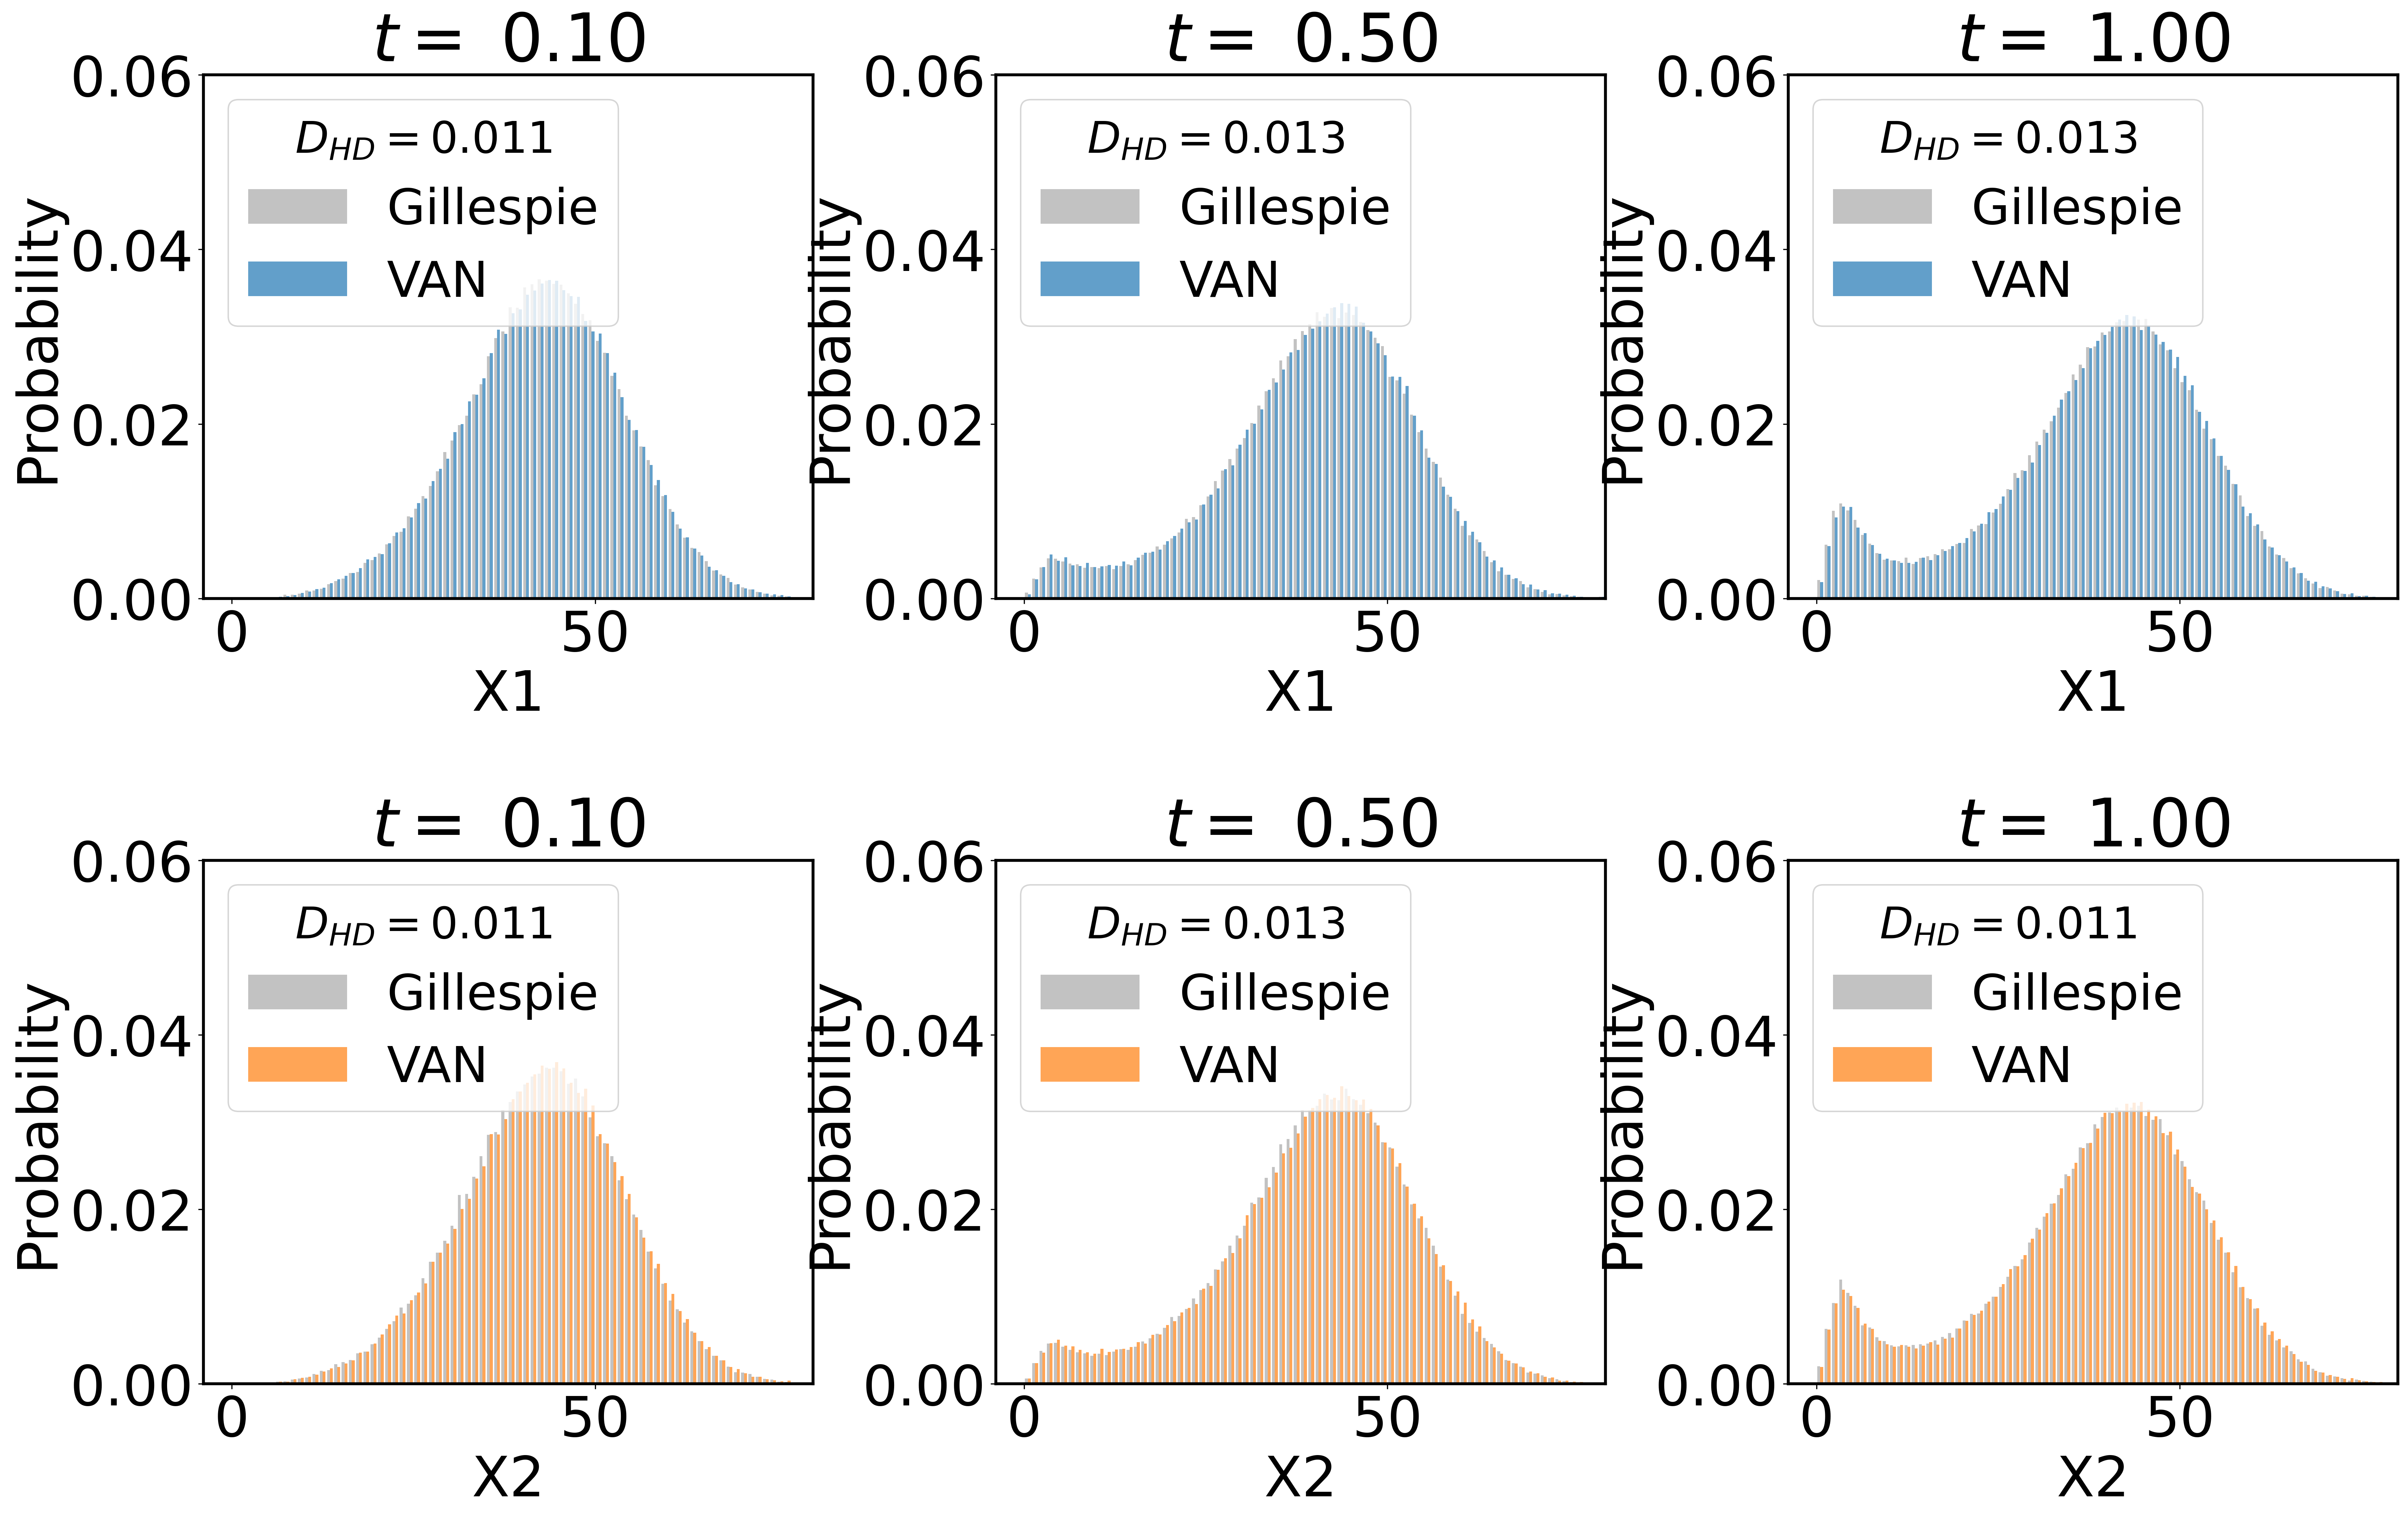

In [ ]:
def hellinger(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / np.sqrt(2)
# Distribution---------------------------
plt.rc('font', size=38)
legendsize = 34
probrange = [0.06] * Sites
Range = [80] * Sites  # Adjust range for all species
Tmax = max(time_points_VAN)
Tlist = [Tmax/10,Tmax/2,Tmax]#[int(Tmax/10),int(Tmax/2),Tmax-1]#[90, 450, 900]
n_row = len(plotlist)  # Number of rows corresponds to Sites
n_col = len(Tlist)  # Number of columns corresponds to time points

fig, axes = plt.subplots(n_row, n_col, figsize=(9 * n_col, 8 * n_row), dpi=300)

for j, T in enumerate(Tlist):
    indexa=np.argmin(np.abs(time_points_SSA - T))#int(T/Gstep)
    indexb=np.argmin(np.abs(time_points_VAN - T))#[int(tt/np.max(TimePoins)*TimePoins.shape[0])]
    print(time_points_SSA[indexa], time_points_VAN[indexb])

    for k, i in enumerate(plotlist):
        if len(plotlist)>1:
            ax = axes[k, j]  # Select the correct subplot
        else:
            ax = axes[k]  # Select the correct subplot
        m1_G = SSA_SampleSum[indexa, i, :]
        m1_V = VAN_SampleSum[:, :, i][indexb]

        sample1 = m1_G#np.random.normal(loc=0, scale=1, size=1000)
        sample2 = m1_V#np.random.normal(loc=2, scale=1.5, size=1000)
        

        bins = np.linspace(min(sample1.min(), sample2.min()), max(sample1.max(), sample2.max()), 50)
        hist1, _ = np.histogram(sample1, bins=bins, density=True)
        hist2, _ = np.histogram(sample2, bins=bins, density=True)
        

        hist1 = hist1 / np.sum(hist1)
        hist2 = hist2 / np.sum(hist2)
        

        hellinger_distance = hellinger(hist1, hist2)
        hd = round(hellinger_distance, 3)
        print(f'Hellinger Distance: {hellinger_distance}')
        
        weights1 = np.ones_like(m1_G) / float(len(m1_G))
        weights2 = np.ones_like(m1_V) / float(len(m1_V))
        ax.hist([m1_G, m1_V], bins=Range[k], range=(0, Range[k]), weights=[weights1, weights2], color=['darkgrey', color[k]], alpha=0.7)
        
        ax.set_xlabel(legend[k])
        ax.set_ylabel('Probability')
        ax.set_title(f"$t=$ {T:.2f}")
        ax.set_xlim(right=Range[k])
        ax.set_ylim(top=probrange[k])
        ax.legend(['Gillespie', 'VAN'], fontsize=legendsize, title='$D_{HD}=$'+str(hd), title_fontsize=30,loc='upper left')
        for spine in ax.spines.values():
            spine.set_linewidth(2)

plt.subplots_adjust(hspace=0.5,wspace=0.3,bottom=0.1)
plt.show()


hist2d: 0 1
['X1', 'X2']
1 0.01
14 0.14
44 0.44
75 0.75


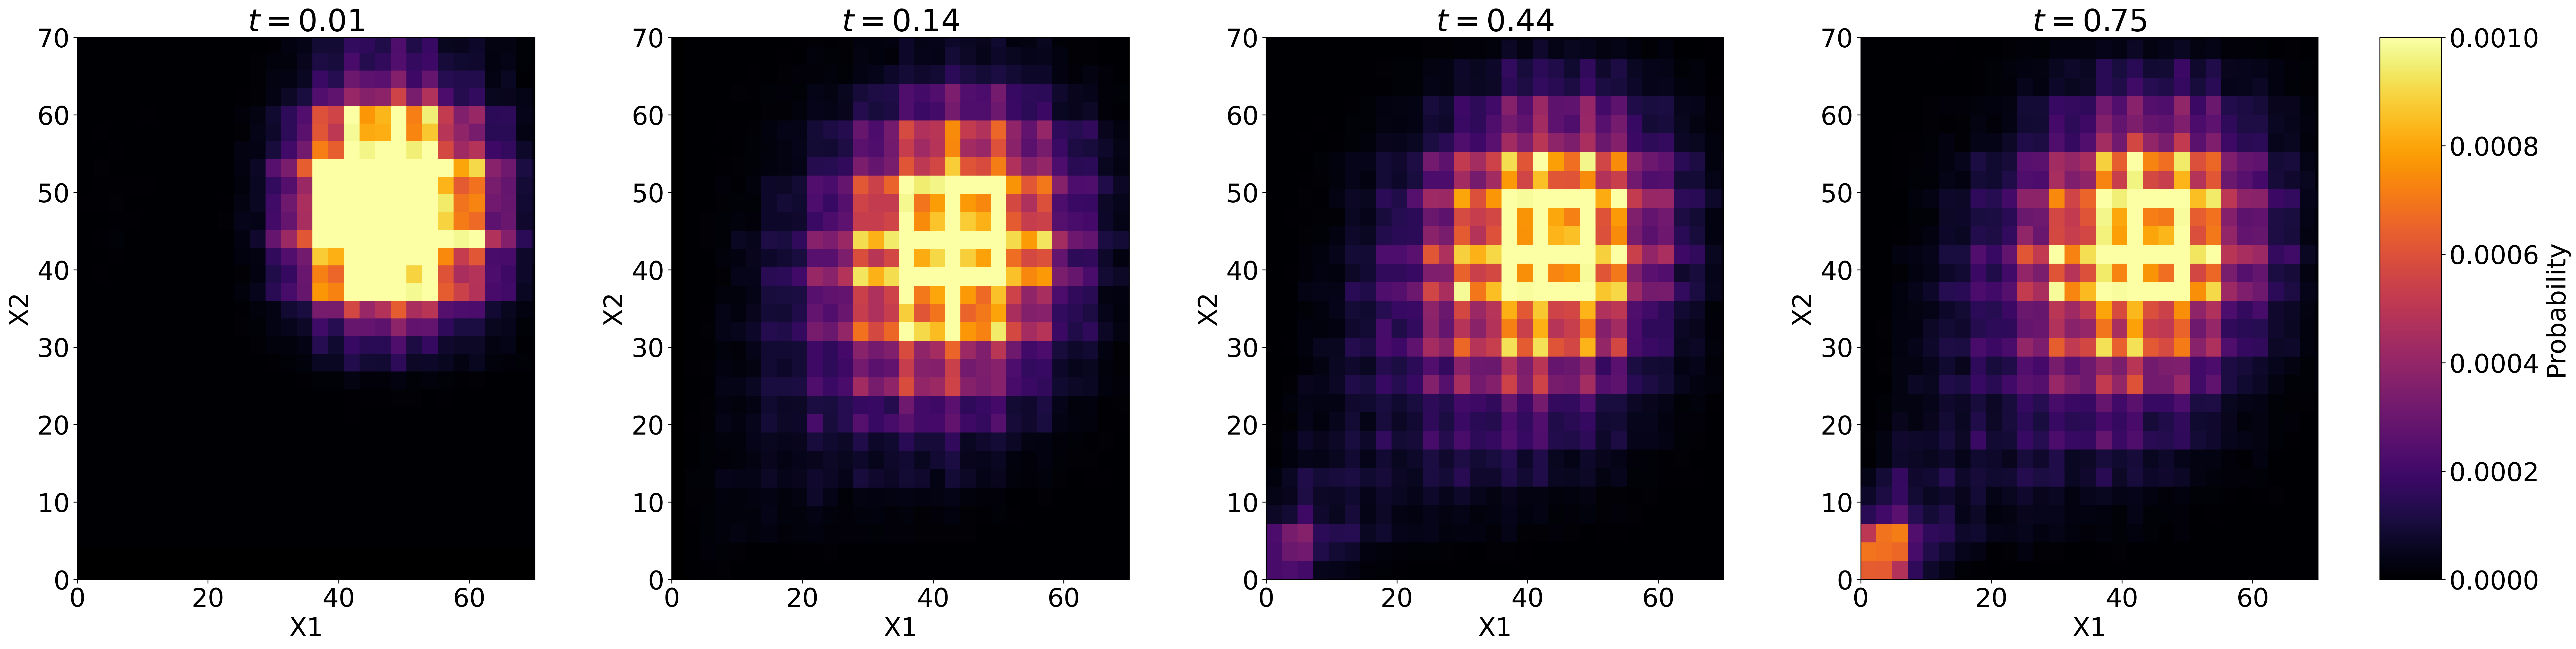

In [ ]:
#hist2d-----------------------------
from matplotlib.colors import LogNorm
plt.rc('font', size=24)
Tmax = max(time_points_VAN)
Tlist = [0.01,0.14,0.44,0.75]
newcmp='inferno'#'viridis'
n_row = 1
n_col = len(Tlist)
k1=Sites-2
k2=Sites-1
print("hist2d:",k1,k2)
print(legend)
fig, axes = plt.subplots(n_row, n_col, figsize=(10*n_col, 9*n_row), dpi=300)
for j, T0 in enumerate(Tlist):
    ax = axes[j] 
    indexb=np.argmin(np.abs(time_points_VAN - T0))
    T=indexb
    print(T,time_points_VAN[T])
    bins=[35,35]
    h=ax.hist2d(VAN_SampleSum[T,:,k1],VAN_SampleSum[T,:,k2],bins=bins,cmap=newcmp,density=True,vmax=1e-3)
    ax.set_facecolor([0/255,0/255,0/255])
    ax.set_xlabel("X"+str(k1+1))
    ax.set_ylabel("X"+str(k2+1))
    ax.set_title("$t=$"+str(T0))
    ax.set_xlim((0,70))
    ax.set_ylim((0,70))

fig.subplots_adjust(right=0.85)  
cbar_ax = fig.add_axes([0.87, 0.1, 0.02, 0.78])  
plt.colorbar(h[3], cax=cbar_ax,label='Probability') 


plt.subplots_adjust(hspace=0.5,wspace=0.3,bottom=0.1)
plt.show()
